In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models
from tqdm import tqdm


2026-01-16 10:34:47.455693: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768559687.709329      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768559687.778497      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768559688.384160      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768559688.384208      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768559688.384212      55 computation_placer.cc:177] computation placer alr

In [4]:
DATA_PATH = "/kaggle/input/mozilla-common-voice-urdu"
AUDIO_PATH = os.path.join(DATA_PATH, "clips")
META_PATH = os.path.join(DATA_PATH, "train.tsv")

SAMPLE_RATE = 16000
DURATION = 5
SAMPLES = SAMPLE_RATE * DURATION
N_MFCC = 40
TOP_SPEAKERS = 10   # keep small for clean results


In [5]:
df = pd.read_csv(META_PATH, sep="\t")
df = df[["path", "client_id"]]
df.dropna(inplace=True)

top_speakers = df["client_id"].value_counts().nlargest(TOP_SPEAKERS).index
df = df[df["client_id"].isin(top_speakers)]

df.head()


,path,client_id
635,common_voice_ur_31941866.mp3,2e93b8a9f03b90a27686fb1bd41e502256ed6d9e4034f2...
636,common_voice_ur_31942200.mp3,2e93b8a9f03b90a27686fb1bd41e502256ed6d9e4034f2...
637,common_voice_ur_31950788.mp3,2e93b8a9f03b90a27686fb1bd41e502256ed6d9e4034f2...
638,common_voice_ur_31950791.mp3,2e93b8a9f03b90a27686fb1bd41e502256ed6d9e4034f2...
639,common_voice_ur_31950872.mp3,2e93b8a9f03b90a27686fb1bd41e502256ed6d9e4034f2...


In [6]:
def preprocess_audio(file_path):
    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    audio, _ = librosa.effects.trim(audio)

    if np.max(np.abs(audio)) != 0:
        audio = audio / np.max(np.abs(audio))

    if len(audio) < SAMPLES:
        audio = np.pad(audio, (0, SAMPLES - len(audio)))
    else:
        audio = audio[:SAMPLES]

    return audio


In [7]:
def extract_mfcc(audio):
    return librosa.feature.mfcc(
        y=audio,
        sr=SAMPLE_RATE,
        n_mfcc=N_MFCC
    )


In [8]:
X = []
y = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    audio_path = os.path.join(AUDIO_PATH, row["path"])
    if not os.path.exists(audio_path):
        continue

    audio = preprocess_audio(audio_path)
    mfcc = extract_mfcc(audio)

    X.append(mfcc)
    y.append(row["client_id"])


100%|██████████| 1934/1934 [01:19<00:00, 24.28it/s]


In [9]:
X = np.array(X)
X = X[..., np.newaxis]

encoder = LabelEncoder()
y = encoder.fit_transform(y)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [11]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=X_train.shape[1:]),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(len(np.unique(y)), activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2026-01-16 10:38:35.954197: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 155, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 77, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 19, 77, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 37, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 37, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,424,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,445,450 (9.33 MB)

 Trainable params: 2,445,258 (9.33 MB)

 Non-trainable params: 192 (768.00 B)

In [12]:
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1
)


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - accuracy: 0.3099 - loss: 4.6859 - val_accuracy: 0.5355 - val_loss: 2.9439
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.8142 - loss: 0.5584 - val_accuracy: 0.8774 - val_loss: 0.4443
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.9387 - loss: 0.1934 - val_accuracy: 0.9484 - val_loss: 0.1996
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.9488 - loss: 0.1544 - val_accuracy: 0.9484 - val_loss: 0.2145
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.9659 - loss: 0.0881 - val_accuracy: 0.9548 - val_loss: 0.2017
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.9797 - loss: 0.0745 - val_accuracy: 0.9677 - val_loss: 0.0986
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.9744 - loss: 0.0649 - val_accuracy: 0.9806 - val_loss: 0.0742
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9876 - loss: 0.0504 - val_accuracy: 0

In [13]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9757 - loss: 0.0963
Test Accuracy: 0.9819121360778809


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


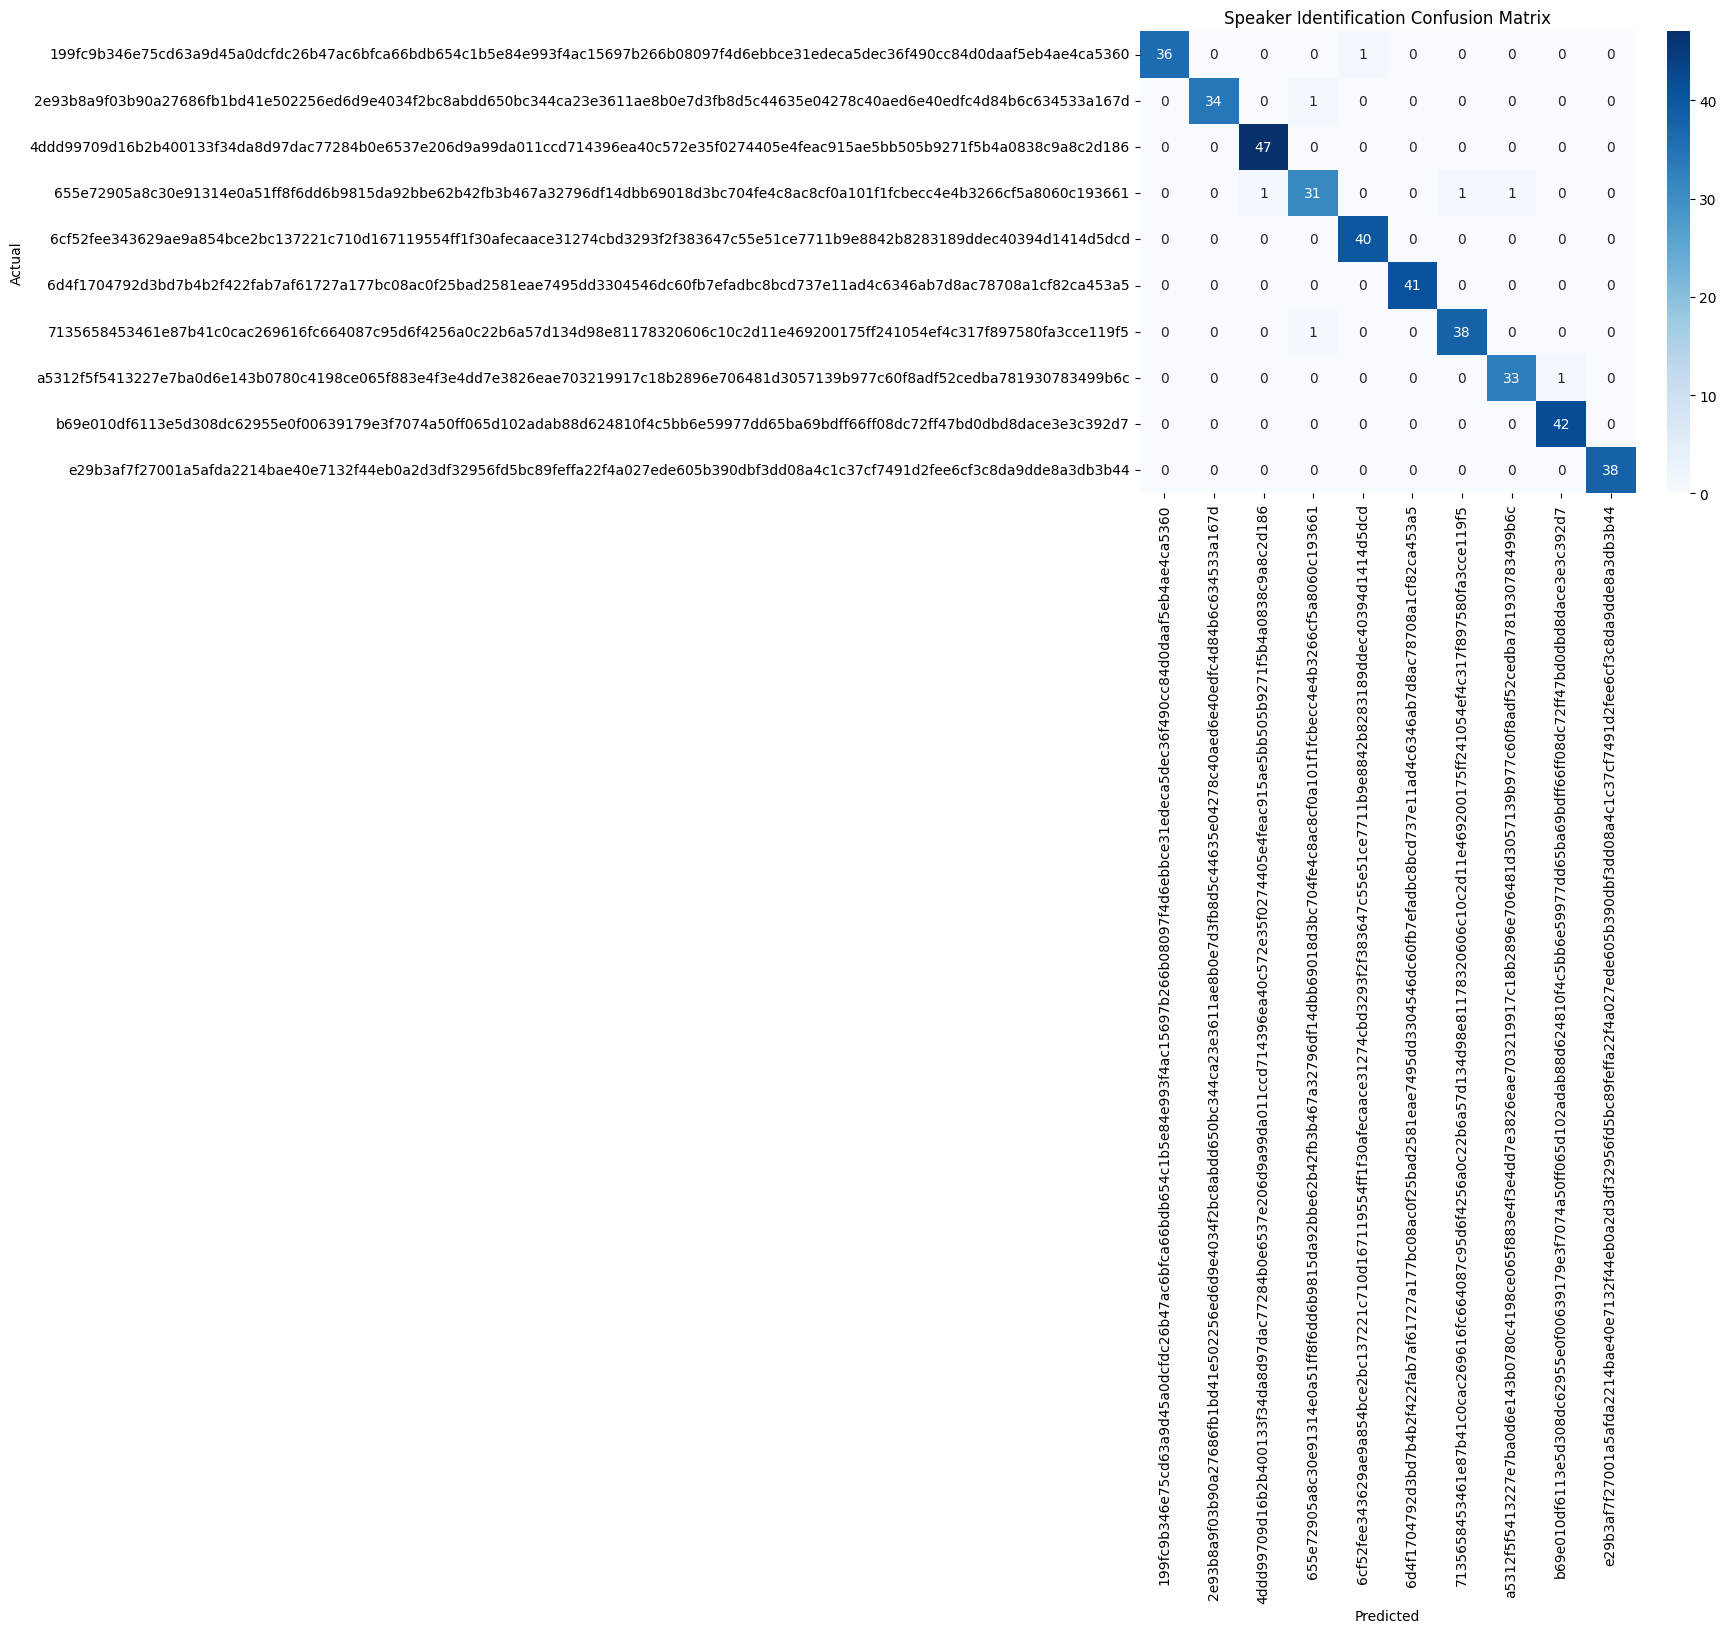

In [14]:
y_pred = np.argmax(model.predict(X_test), axis=1)

labels = np.unique(y_test)

cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=encoder.inverse_transform(labels),
    yticklabels=encoder.inverse_transform(labels)
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Speaker Identification Confusion Matrix")
plt.show()


In [15]:
print(classification_report(
    y_test,
    y_pred,
    labels=labels,
    target_names=encoder.inverse_transform(labels)
))


                                                                                                                                  precision    recall  f1-score   support

199fc9b346e75cd63a9d45a0dcfdc26b47ac6bfca66bdb654c1b5e84e993f4ac15697b266b08097f4d6ebbce31edeca5dec36f490cc84d0daaf5eb4ae4ca5360       1.00      0.97      0.99        37
2e93b8a9f03b90a27686fb1bd41e502256ed6d9e4034f2bc8abdd650bc344ca23e3611ae8b0e7d3fb8d5c44635e04278c40aed6e40edfc4d84b6c634533a167d       1.00      0.97      0.99        35
4ddd99709d16b2b400133f34da8d97dac77284b0e6537e206d9a99da011ccd714396ea40c572e35f0274405e4feac915ae5bb505b9271f5b4a0838c9a8c2d186       0.98      1.00      0.99        47
655e72905a8c30e91314e0a51ff8f6dd6b9815da92bbe62b42fb3b467a32796df14dbb69018d3bc704fe4c8ac8cf0a101f1fcbecc4e4b3266cf5a8060c193661       0.94      0.91      0.93        34
6cf52fee343629ae9a854bce2bc137221c710d167119554ff1f30afecaace31274cbd3293f2f383647c55e51ce7711b9e8842b8283189ddec40394d1414d5dcd       0.98      1.00